# TReNDS - Exploring tabular augmentation

Augmentation is broadly used for sample generation and regularization in image classification. This is an experiment to use the techniques on tabular data. I'm starting here with mixup and may add more in the future, if I feel motivated.

## Credits
Many ideas of my notebook are derived from this [notebook](https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964#MixUp) from the Bengaliai competition earlier this year. Please go there and upvote if you find this or other references usefull.
Here are the references in detail:
- https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964#MixUp: Multi head - metrics, - loss function, - mixup.
- https://github.com/fastai/fastai/tree/master/fastai: mixup and many more
- https://forums.fast.ai/t/tabulardata-mixup/52011/6: tabular mixup

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from fastai.tabular import * 
from fastai import *

import os, shutil
import sys

In [2]:
# Notebook Settings

# np.set_printoptions(threshold=sys.maxsize)

In [3]:
kaggle_path = Path('.')
kaggle_input_path = Path('/kaggle/input/trends-assessment-prediction')

#for dirname, _, filenames in os.walk(kaggle_input_path):
#    print(dirname, filenames)

# Parameters

In [4]:
INCLUDE_FNC_DATA = False
IMPUTATION_STRAT = 'IGNORE_ON_TRAIN' # 'IGNORE_ON_TRAIN', 'MEAN' 
LOSS_BASE = 'MSE' # 'L1'
LOSS_WEIGHTS = [0.4, 0.15, 0.15, 0.15, 0.15]
BS = 128

# Prepare data

In [5]:
l_data = pd.read_csv(kaggle_input_path/'loading.csv')

if INCLUDE_FNC_DATA:
    f_data = pd.read_csv(kaggle_input_path/'fnc.csv')
    l_data = l_data.merge(f_data, on='Id', how = 'inner')

y_data = pd.read_csv(kaggle_input_path/'train_scores.csv')

idx_site2 = pd.read_csv(kaggle_input_path/'reveal_ID_site2.csv')
#submission = pd.read_csv(kaggle_input_path/'sample_submission.csv')

In [6]:
display(y_data.head())
display(y_data.describe())
y_data.shape

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5439.000000,5439.000000,5838.000000,5838.000000
mean,15909.667007,50.034068,51.474692,59.244132,47.325130,51.905658
std,3411.775315,13.539881,10.188354,11.387595,11.124863,11.839203
min,10001.000000,14.257265,15.769168,1.021874,0.991172,0.815285
25%,12961.000000,40.129361,44.781240,52.396805,40.122682,44.514880
50%,15925.000000,50.427747,51.847306,60.052535,47.811205,52.572032
75%,18886.000000,59.580851,58.495576,67.142611,55.058014,59.910146
max,21754.000000,84.491113,81.325580,94.702874,82.164478,94.509903


(5877, 6)

In [7]:
display(l_data.tail())
display(l_data.describe()),
l_data.shape

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
11749,21750,0.005996,0.003873,0.012353,0.000242,-0.002159,0.020201,0.020931,0.003684,-0.002458,...,0.011454,0.022840,0.006448,-0.007203,0.029689,0.004942,0.007751,-0.020226,0.028821,0.017492
11750,21751,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,...,0.012303,0.018314,0.012326,-0.012152,0.024617,0.002096,0.001911,-0.008028,0.035093,0.017439
11751,21752,0.000627,0.011407,0.010957,0.000534,-0.000347,0.013499,0.010541,0.001867,0.007447,...,0.012055,0.020741,0.001160,-0.007140,0.025236,0.002026,0.001876,-0.014612,0.021665,0.019592
11752,21753,0.007431,0.021419,0.014143,-0.005623,-0.006399,0.008602,0.006831,-0.001018,0.014972,...,0.019220,0.026282,0.020715,-0.008130,0.025149,0.007695,0.003226,-0.003505,0.029326,0.014235
11753,21754,0.010670,0.010670,0.006662,-0.002215,-0.001773,0.006544,0.010900,0.000563,0.002995,...,0.012511,0.023367,0.010739,-0.007732,0.015962,0.002420,0.003115,-0.020373,0.023804,0.012477


,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,...,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,15877.500000,0.005423,0.009251,0.010635,0.001054,-0.001271,0.013410,0.013749,0.001988,0.005053,...,0.010036,0.020869,0.009754,-0.008081,0.023412,0.005084,0.003595,-0.014729,0.026623,0.016187
std,3393.231867,0.004552,0.004153,0.003609,0.003591,0.002658,0.004032,0.003905,0.003200,0.005296,...,0.003914,0.003542,0.004609,0.003267,0.004578,0.003697,0.002846,0.005972,0.004039,0.003731
min,10001.000000,-0.015894,-0.015927,-0.002240,-0.013459,-0.015118,-0.002929,0.001156,-0.009622,-0.027575,...,-0.005282,0.008878,-0.010426,-0.020051,0.008485,-0.007969,-0.007720,-0.040384,0.013261,0.001266
25%,12939.250000,0.002527,0.006495,0.008159,-0.001319,-0.002904,0.010764,0.011048,-0.000185,0.002079,...,0.007356,0.018471,0.006692,-0.010231,0.020266,0.002550,0.001677,-0.018738,0.023791,0.013595
50%,15877.500000,0.005546,0.009192,0.010572,0.000956,-0.001132,0.013513,0.013545,0.001917,0.005605,...,0.009942,0.020620,0.009860,-0.008101,0.023231,0.004953,0.003539,-0.014498,0.026411,0.016031
75%,18815.750000,0.008476,0.011990,0.013009,0.003432,0.000535,0.016087,0.016186,0.004113,0.008734,...,0.012616,0.023098,0.012876,-0.005915,0.026302,0.007421,0.005454,-0.010635,0.029244,0.018599
max,21754.000000,0.024189,0.029621,0.026218,0.022613,0.007863,0.028797,0.035586,0.015763,0.022121,...,0.028522,0.036454,0.026258,0.005262,0.045043,0.029049,0.016599,0.005710,0.044570,0.032066


(11754, 27)

## Impute missing data

In [8]:
if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
    ## will later ignore the value when executing the loss function
    y_data = y_data.fillna(0)
else: #'MEAN'
    y_data = y_data.fillna(mean())
    
y_data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,0.000000,0.000000,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


## Combine Xs and Ys

In [9]:
train = l_data.merge(y_data, on='Id', how='inner').sort_values(by='Id').reset_index(drop = True)
idx_train = train.pop('Id') 
train

,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,...,IC_20,IC_30,IC_22,IC_29,IC_14,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,0.029223,...,0.010496,0.002892,-0.023235,0.022177,0.017192,57.436077,30.571975,62.553736,53.325130,51.427998
1,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,0.027333,...,0.005739,0.002880,-0.016609,0.025543,0.014524,59.580851,50.969456,67.470628,60.651856,58.311361
2,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,0.027787,...,-0.000319,0.005866,-0.015182,0.024476,0.014760,71.413018,53.152498,58.012103,52.418389,62.536641
3,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,0.021058,...,0.000786,0.002692,-0.019814,0.017105,0.013316,66.532630,0.000000,0.000000,52.108977,69.993075
4,0.005192,0.010585,0.012160,-0.000920,-0.002255,0.011416,0.013838,0.001929,0.003051,0.031867,...,0.003731,0.000733,-0.008462,0.026733,0.014358,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,-0.001115,0.007108,0.008652,0.003596,0.000950,0.016314,0.017090,0.003513,0.004217,0.027352,...,0.006943,0.003312,-0.011562,0.032932,0.011053,14.257265,21.358872,61.165998,51.778483,54.640179
5873,0.007263,0.016489,0.012704,0.004357,-0.005044,0.013909,0.019284,-0.006267,-0.000456,0.031161,...,0.001316,0.003792,-0.022357,0.031624,0.016982,55.456978,68.169675,29.907995,55.349257,54.019517
5874,0.005996,0.003873,0.012353,0.000242,-0.002159,0.020201,0.020931,0.003684,-0.002458,0.033895,...,0.004942,0.007751,-0.020226,0.028821,0.017492,48.948756,55.114811,60.878271,38.617246,50.679885
5875,0.000627,0.011407,0.010957,0.000534,-0.000347,0.013499,0.010541,0.001867,0.007447,0.020901,...,0.002026,0.001876,-0.014612,0.021665,0.019592,66.532630,59.844808,72.303110,55.458281,46.870235


In [10]:
test = l_data.merge(y_data, on='Id', how='outer', indicator = True)
test = test[test['_merge'] == 'left_only'].drop(['age',
                                                 'domain1_var1', 
                                                 'domain1_var2',
                                                 'domain2_var1',
                                                 'domain2_var2',
                                                 '_merge'], axis = 1).sort_values(by='Id').reset_index(drop = True)
idx_test = test.pop('Id') 
test

,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,IC_04,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,0.038530,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
1,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,0.038693,...,0.006948,0.019818,0.003582,-0.010414,0.023518,0.005929,0.005046,-0.030771,0.028500,0.022485
2,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,0.033243,...,0.001252,0.020002,0.013935,-0.005653,0.013281,0.003379,0.004841,-0.009467,0.027287,0.014542
3,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,0.029094,...,0.014015,0.022257,0.008814,-0.003944,0.027572,0.008287,0.000210,-0.013350,0.033612,0.019472
4,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,0.027038,...,0.010726,0.026314,0.007632,-0.010203,0.022945,0.007642,0.003368,-0.024025,0.024723,0.024084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,0.005406,0.006275,0.012252,0.003518,0.001400,0.015054,0.015373,0.001532,0.003546,0.035930,...,0.009398,0.024635,0.013140,-0.007455,0.023625,0.005393,0.007665,-0.011987,0.027616,0.018392
5873,0.004240,0.009213,0.010981,0.000443,-0.003072,0.010702,0.014673,0.005523,0.005780,0.022570,...,0.011172,0.017172,0.003079,-0.007329,0.021157,0.007605,0.009629,-0.019956,0.024192,0.017368
5874,0.004783,0.017910,0.012128,-0.005683,-0.011613,0.017000,0.007230,0.001315,0.008788,0.030379,...,0.010015,0.017097,0.016017,-0.003296,0.018724,0.008006,-0.000521,-0.001333,0.029249,0.015356
5875,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,0.023853,...,0.012303,0.018314,0.012326,-0.012152,0.024617,0.002096,0.001911,-0.008028,0.035093,0.017439


# Model

## Metrics

In [11]:
# variation of https://github.com/fastai/fastai/blob/master/fastai/metrics.py#L85

def norm_absolute_error(preds, targs):
    "Normalized absolute error between `pred` and `targ`."
    sg=targs.sign()
    y=targs*sg
        
    pred, targ = flatten_check(preds*sg, y)
    return torch.abs(targ - pred).sum() / targ.sum()

def weighted_nae(preds, targs):
    return 0.3 * norm_absolute_error(preds[:,0],targs[:,0]) + \
           0.175 * norm_absolute_error(preds[:,1],targs[:,1]) + \
           0.175 * norm_absolute_error(preds[:,2],targs[:,2]) + \
           0.175 * norm_absolute_error(preds[:,3],targs[:,3]) + \
           0.175 * norm_absolute_error(preds[:,4],targs[:,4])

The customized metric callback is a variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964. 
It is used to keep track of the five single targets and the combined metric. 

In [12]:
# variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964

class Metric_idx(Callback):
    def __init__(self, idx):
        super().__init__()
        self.idx = idx
        
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = Tensor([]), Tensor([])
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[self.idx]
        
        self.preds = torch.cat((self.preds, last_output.float().cpu()))
        self.targs = torch.cat((self.targs, last_target.float().cpu()))
        
    def _norm_absolute_error(self):
        return norm_absolute_error(self.preds, self.targs)
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._norm_absolute_error())

    
Metric_age = partial(Metric_idx,0)
Metric_domain1_var1 = partial(Metric_idx,1)
Metric_domain1_var2 = partial(Metric_idx,2)
Metric_domain2_var1 = partial(Metric_idx,3)
Metric_domain2_var2 = partial(Metric_idx,4)

class Metric_total(Callback):
    def __init__(self):
        super().__init__()
        self.age = Metric_idx(0)
        self.domain1_var1 = Metric_idx(1)
        self.domain1_var2 = Metric_idx(2)
        self.domain2_var1 = Metric_idx(3)
        self.domain2_var2 = Metric_idx(4)
        
    def on_epoch_begin(self, **kwargs):
        self.age.on_epoch_begin(**kwargs)
        self.domain1_var1.on_epoch_begin(**kwargs)
        self.domain1_var2.on_epoch_begin(**kwargs)
        self.domain2_var1.on_epoch_begin(**kwargs)
        self.domain2_var2.on_epoch_begin(**kwargs)
        
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.age.on_batch_end(last_output, last_target, **kwargs)
        self.domain1_var1.on_batch_end(last_output, last_target, **kwargs)
        self.domain1_var2.on_batch_end(last_output, last_target, **kwargs)
        self.domain2_var1.on_batch_end(last_output, last_target, **kwargs)
        self.domain2_var2.on_batch_end(last_output, last_target, **kwargs)
 
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 
                           0.3 * self.age._norm_absolute_error() +
                           0.175*self.domain1_var1._norm_absolute_error()  +
                           0.175*self.domain1_var2._norm_absolute_error()  +
                           0.175*self.domain2_var1._norm_absolute_error()  +
                           0.175*self.domain2_var2._norm_absolute_error()
                          )

## Loss function
The customized metric callback is a variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964. It weights and combines the five single losses.

In [13]:
# variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964

class Loss_combine(nn.Module):
    def __init__(self, loss_weights = [0.4,0.15,0.15,0.15,0.15], loss_base = 'MSE'):
        super().__init__()
        
        self.loss_base = loss_base
        
        self.loss_weights = loss_weights
        self.fw = Tensor(LOSS_WEIGHTS).cuda()
          
            
    def forward(self, input, target,reduction='mean'): #mean
        
        x0,x1,x2,x3,x4 = input.T
        
        if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
            sg = target.float().sign()
            x0,x1,x2,x3,x4 = x0.float()*sg[:,0],x1.float()*sg[:,1],x2.float()*sg[:,2],x3.float()*sg[:,3],x4.float()*sg[:,4]
        else: # 'MEAN'
            sg = 1
            x0,x1,x2,x3,x4 = x0.float(),x1.float(),x2.float(),x3.float(),x4.float()
            
        y = target.float()*sg
        
        if self.loss_base == 'MSE':
            loss_func = F.mse_loss 
            reduction = 'sum'
            return self.fw[0]*loss_func(x0,y[:,0],reduction=reduction)/sum(y[:,0]**2) + \
               self.fw[1]*loss_func(x1,y[:,1],reduction=reduction)/sum(y[:,1]**2) + \
               self.fw[2]*loss_func(x2,y[:,2],reduction=reduction)/sum(y[:,2]**2) + \
               self.fw[3]*loss_func(x3,y[:,3],reduction=reduction)/sum(y[:,3]**2) + \
               self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)/sum(y[:,4]**2)
        else: # 'L1'
            loss_func = F.l1_loss 
            reduction = 'mean'
            return self.fw[0]*loss_func(x0,y[:,0],reduction=reduction) + \
               self.fw[1]*loss_func(x1,y[:,1],reduction=reduction) + \
               self.fw[2]*loss_func(x2,y[:,2],reduction=reduction) + \
               self.fw[3]*loss_func(x3,y[:,3],reduction=reduction) + \
               self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)


### Augmentation
Augmentation is broadly used for sample generation and regularization in image classification. This is a try to use the techniques on tabular data.

The Mixup implementation is a variation of https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py following this [example](https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964#MixUp) and adaptied for tabular data following this [thread](https://forums.fast.ai/t/tabulardata-mixup/52011/6).

In [14]:
# Vartiation https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py#L8
# and https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964#MixUp
# and https://forums.fast.ai/t/tabulardata-mixup/52011/6

class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'): #mean
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 11:
            loss1, loss2 = self.crit(output,target[:,0:5].long()), self.crit(output,target[:,5:10].long())
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  d = self.crit(output, target)
        
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        
        # last_input[0] ==> embedded categorical data
        # last_input[1] ==> continous data
        rnd = 1
        #if .5<np.random.uniform():
        #    rnd=np.random.uniform()/20
        
        l_org = last_input[1] * rnd
        last_input = last_input[1] *rnd #0
        
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        
        return {'last_input': [l_org, new_input], 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
            


## Build the model

In [15]:
bs = 128
valid_idx = range(200, 400)
dep_var = ['age','domain1_var1','domain1_var2', 'domain2_var1', 'domain2_var2']
    
def prep_data(bs, valid_idx):
    procs = [FillMissing, Categorify, Normalize]
    cont_names = list(set(train.columns) - set(['age','domain1_var1','domain1_var2', 'domain2_var1', 'domain2_var2'])-set(dep_var))
    cat_names = []

    tlist = (TabularList.from_df(train, 
                                path=kaggle_path, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                procs=procs))

    if valid_idx == None:
        tlist = tlist.split_none()
    else:
        tlist = tlist.split_by_idx(valid_idx)

    data = (tlist.label_from_df(cols=dep_var)
                 .add_test(TabularList.from_df(test, 
                                               cat_names=cat_names,
                                               cont_names=cont_names, 
                                               procs = procs))
                 .databunch(path = kaggle_path, bs = bs))
    
    return data


def prep_learn(data):
    
    learn = tabular_learner(data, 
                        layers = [256,128,256,128,64], #[1024,1024,128,1024,128,1024,1024],#
                        ps = 0.3,
                        loss_func = Loss_combine(loss_weights = LOSS_WEIGHTS,  loss_base= LOSS_BASE),
                        metrics=[Metric_age(),
                                 Metric_domain1_var1(),
                                 Metric_domain1_var2(),
                                 Metric_domain2_var1(),
                                 Metric_domain2_var2(),
                                 Metric_total()],
                       y_range=(Tensor([12,12,0,0,0]).cuda(),Tensor([90,90,100,100,100]).cuda())
                       )#.to_fp16()

    learn.clip_grad = 1.0
    
    return learn
    

## Training experiment without augmentation

In [16]:
data = prep_data(bs, valid_idx)
learn = prep_learn(data)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 6.31E-02


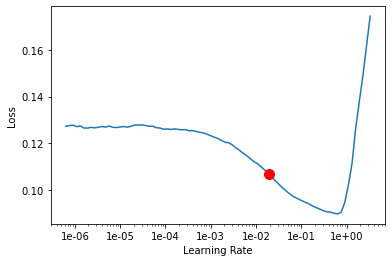

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
lr = 2e-2
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(10, lr, callbacks=[reduceLR])

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.074394,0.048378,0.145570,0.213363,0.129116,0.179113,0.142790,0.159938,00:01
1,0.052765,0.043694,0.155490,0.214983,0.108319,0.162541,0.146863,0.157370,00:01
2,0.046849,0.045779,0.144407,0.205495,0.145344,0.180382,0.114338,0.156295,00:01
3,0.043979,0.043865,0.143256,0.198130,0.108025,0.169836,0.112460,0.145956,00:01
4,0.042460,0.041618,0.149572,0.191454,0.122807,0.178340,0.128675,0.153595,00:01
5,0.041359,0.041149,0.143344,0.202726,0.134747,0.163548,0.142162,0.155560,00:01
6,0.040672,0.041102,0.144628,0.192464,0.120680,0.171071,0.132269,0.151273,00:01
7,0.039947,0.041226,0.144693,0.206070,0.123777,0.168625,0.135892,0.154422,00:01
8,0.039220,0.040978,0.139290,0.201899,0.131046,0.166693,0.132535,0.152417,00:01
9,0.038982,0.041033,0.140769,0.202486,0.128595,0.166356,0.133225,0.152596,00:01


In [19]:
yv, yv_truth= learn.get_preds(ds_type=DatasetType.Valid)
yt, yt_truth= learn.get_preds(ds_type=DatasetType.Train)

print(f'Without augmentation:')
print(f'Weighted normalized absolute error (Valid): {weighted_nae(yv,yv_truth)}')
print(f'Weighted normalized absolute error (Train): {weighted_nae(yt,yt_truth)}')


Without augmentation:
Weighted normalized absolute error (Valid): 0.1666399985551834
Weighted normalized absolute error (Train): 0.15863674879074097


## Training experiment with augmentation

In [20]:
data = prep_data(bs, valid_idx)
learn = prep_learn(data)

lr = 2e-2
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(10, lr, callbacks=[MixUpCallback(learn, alpha=0.4),reduceLR])

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_idx,metric_idx,metric_total,time
0,0.074599,0.047370,0.147260,0.217852,0.146760,0.160210,0.147791,0.161885,00:02
1,0.056145,0.044359,0.141088,0.232976,0.134788,0.169377,0.134513,0.159866,00:01
2,0.051165,0.046093,0.143940,0.216906,0.120940,0.150752,0.187125,0.161433,00:01
3,0.049076,0.043026,0.142077,0.204314,0.144695,0.176401,0.138936,0.158884,00:02
4,0.047578,0.041334,0.141251,0.202758,0.140460,0.171068,0.151608,0.158907,00:01
5,0.046257,0.041406,0.147281,0.197755,0.139337,0.170109,0.153160,0.159747,00:01
6,0.045604,0.041277,0.132730,0.207298,0.131345,0.170272,0.133882,0.152309,00:02
7,0.045191,0.041431,0.139081,0.204365,0.137816,0.169818,0.145324,0.156756,00:01
8,0.044836,0.040859,0.137706,0.200681,0.131503,0.165386,0.136190,0.152220,00:01
9,0.044511,0.040919,0.136772,0.200979,0.136945,0.168025,0.141059,0.154258,00:01


In [21]:
yv, yv_truth= learn.get_preds(ds_type=DatasetType.Valid)
yt, yt_truth= learn.get_preds(ds_type=DatasetType.Train)

print(f'With augmentation:')
print(f'Weighted normalized absolute error (Valid): {weighted_nae(yv,yv_truth)}')
print(f'Weighted normalized absolute error (Train): {weighted_nae(yt,yt_truth)}')


With augmentation:
Weighted normalized absolute error (Valid): 0.1668575406074524
Weighted normalized absolute error (Train): 0.16082099080085754


## Training conclution

The choosen augmentation technique in this configuration doesn't improve the validation score. 

Let's see if it generalizes better on the LB.

# Prediction

In [22]:
def make_submission(learn, postfix = ''):
    preds = learn.get_preds(ds_type=DatasetType.Test)[0]
    
    rec = pd.DataFrame(idx_test)
    rec['Id'] = rec['Id'].astype(str)+'_'
    rec['Predicted'] = preds[:,1]
    
    submission=None

    for t, tcol in enumerate(dep_var):
        rec = pd.DataFrame(idx_test)
        rec['Id'] = rec['Id'].astype(str)+'_'+tcol
        rec['Predicted'] = preds[:,t]
        if isinstance(submission, pd.DataFrame):
            submission = submission.append(rec)
        else:
            submission = rec

    submission = submission.sort_values('Id').reset_index(drop=True)
    
    display(submission.head(10))
    submission.to_csv('submission'+postfix+'.csv', index=False)

## Predict without augmentation

In [23]:
data = prep_data(bs, valid_idx = None)
learn = prep_learn(data)

lr = 2e-2
learn.fit_one_cycle(10, lr)

In [24]:
make_submission(learn, postfix = '_wo_aug')

,Id,Predicted
0,10003_age,45.986549
1,10003_domain1_var1,49.061516
2,10003_domain1_var2,58.304142
3,10003_domain2_var1,46.252407
4,10003_domain2_var2,54.012333
5,10006_age,62.886322
6,10006_domain1_var1,54.765713
7,10006_domain1_var2,59.264137
8,10006_domain2_var1,50.623482
9,10006_domain2_var2,50.019474


## Predict with augmentation

In [25]:
data = prep_data(bs, valid_idx = None)
learn = prep_learn(data)

lr = 2e-2
learn.fit_one_cycle(10, lr, callbacks=[MixUpCallback(learn, alpha=0.4)])

In [26]:
make_submission(learn, postfix = '_with_aug')

,Id,Predicted
0,10003_age,46.059483
1,10003_domain1_var1,49.057041
2,10003_domain1_var2,58.605530
3,10003_domain2_var1,46.528221
4,10003_domain2_var2,53.103851
5,10006_age,56.708973
6,10006_domain1_var1,53.018108
7,10006_domain1_var2,58.169304
8,10006_domain2_var1,48.636211
9,10006_domain2_var2,50.629307


# Conclusion
LB without augmentation: 0.164

LB with augmentation: 0.165

==> No advantage from augmentation is this particular setting. Got to try something else ... ;)